# Échauffement de Python
*Maxime Sangnier*

Septembre 2021

**Le cahier IPYNB et le fichier HTML associé sont à rendre au plus tard le vendredi 17/09/21 dans [ce dossier distant](https://www.dropbox.com/request/W4xUEk5K0L6uZ1bENg0n).**

**Avant de générer le fichier HTML, merci de lancer RESTART KERNEL AND RUN ALL CELLS. L'exécution doit se dérouler sans erreur et les cellules doivent être numérotées de manière consécutive.**

# Table of contents
1. [Inégalité de Hoeffding](#part1)
1. [Traitement d'un jeu de donnée](#part2)
1. [Optimisation numérique](#part3)


# Inégalité de Hoeffding <a id="part1"></a>
>L'objectif de cet exercice est d'illustrer numériquement l'inégalité de Hoeffding, dont l'énoncé suit.

><div style="padding:3px; padding-left:6px; border:1px dotted #d0d0d0; border-left:4px solid #d0d0d0; margin-left:20px; margin-bottom:15px; font-style:italic;">
<strong>Inégalité de Hoeffding</strong>:
    Soient $X_1, \dots, X_n$ $n$ variables aléatoires indépendantes à valeurs dans $[0, 1]$ et $\bar X_n = \frac 1n \sum_{i=1}^n X_i$.
    Alors, pour tout $t>0$,
    $$
        \mathbb P \left(\left| \bar X_n - \mathbb E [\bar X_n] \right | \ge t \right)
        \le 2 e^{-2nt^2}.
    $$
</div>

>Pour ce faire, on propose d'utiliser un $n$-échantillon $(X_1, \dots, X_n)$ de variables aléatoires i.i.d. suivant une loi Beta $\mathcal B(\alpha, \beta)$ de paramètres $\alpha = \beta = 0.2$ et d'estimer la probabilité $\mathbb P \left(\left| \bar X_n - \mathbb E [\bar X_n] \right | \ge t \right)$ à l'aide de $N$ $n$-échantillons indépendants.

>Votre réponse ne devra faire intervenir aucune **boucle**.

>**Thèmes abordés** : paquet `scipy.stats`, méthodes de `numpy` et `numpy.array`, utilisation de `matplotlib`, compréhension de liste.

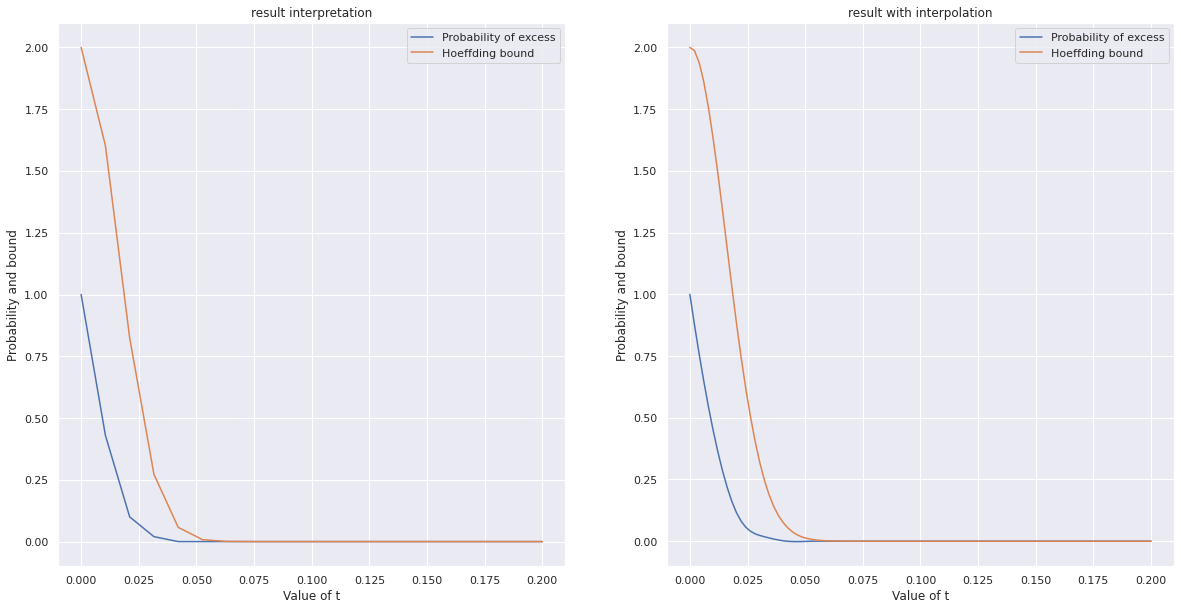

In [1]:
# Answer
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# number of variables i.d.d (n)
n = 1000
# number of 𝑛-échantillons indépendants (N)
N = 100
# value space for t
t = np.linspace(0, 0.2, 20)

# Generate samples
a = b = 0.2
s = beta.rvs(a, b, size=N*n).reshape(N, n)

# calculate mean for each échantillon
m = s.mean(axis=1)

# get experience of the distribution
e = beta.stats(a, b, moments='m')

# get distance from the mean and experience
d = np.abs(m - e)

# estimate the probability for all the t
tv =  np.expand_dims(t, axis=-1) # add a dimension for t
P = (d >= tv).mean(axis=1)

# calculate Hoeffding bound
H = 2 * np.exp(-2*n*t**2)

# plot the results
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(t, P, label="Probability of excess")
ax[0].plot(t, H, label="Hoeffding bound")
ax[0].set_xlabel('Value of t')
ax[0].set_ylabel('Probability and bound')
ax[0].set_title('result interpretation')
ax[0].legend()

# plot the result with Cubic Spline Interpolation
f_inter_P = interp1d(t, P, kind='cubic')
f_inter_H = interp1d(t, H, kind='cubic')
x_plot = np.linspace(0, 0.2, 100)
ax[1].plot(x_plot, f_inter_P(x_plot), label="Probability of excess")
ax[1].plot(x_plot, f_inter_H(x_plot), label="Hoeffding bound")
ax[1].set_xlabel('Value of t')
ax[1].set_ylabel('Probability and bound')
ax[1].set_title('result with interpolation')
ax[1].legend()


# Traitement d'un jeu de donnée <a id="part2"></a>
>On cherche à comparer les erreurs empirique et de généralisation d'un modèle de régression (`reg` ici) en fonction du paramètre `gamma`.
Pour ce faire :
> - Charger le jeu de données enregistré dans [data.csv](http://www.lpsm.paris/pageperso/sangnier/files/pythonM2/data.csv) (le nom est un lien cliquable).
La dernière colonne représente les valeurs à expliquer.
> - Normaliser le jeu de données (moyennes et écarts types empiriques de cache variable explicative ramenés respectivement à 0 et 1).
> - Séparer le jeu de données en deux sous-ensembles : un d'apprentissage qui servira à estimer les paramètres du modèle et à calculer l'erreur empirique, l'autre de test qui permettra d'estimer l'erreur de généralisation.
> - Tracer les courbes des deux erreurs (apprentissage et test) pour différentes valeurs du paramètre `gamma`.

>**Thèmes abordés** : chargement d'un jeu de données avec `pandas`, utilisation de `scikit-learn`, standardisation, séparation, sur-apprentissage.

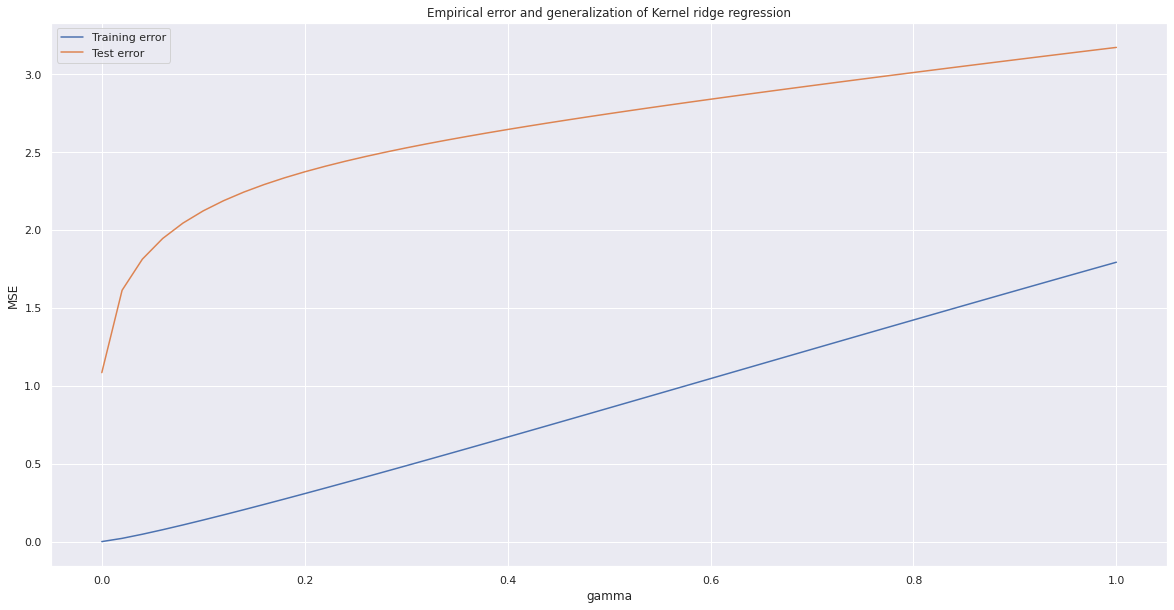

In [2]:
# Answer

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

data = pd.read_csv("data.csv", sep=";", header=None)
data = shuffle(data)
# separate variables
X = data.iloc[:, 0:5]
y = data.iloc[:, 5]

# standarise variables
# what we are going to do hereo is to set mean and var to 0 and 1, so it is standarize, not normalise
X -= X.mean(axis=0)
X /= X.std(axis=0)

# split training dataset and testing dataset
n = 150
X_train = X[:n]
X_test = X[n:]
y_train = y[:n]
y_test = y[n:]

gamma = np.linspace(1, 0, 51)
# we do the fitting, prediction and mse (mean square error) evaluation here
mse_train = np.zeros(len(gamma))
mse_test = np.zeros(len(gamma))
for i, g in enumerate(gamma):
    reg = KernelRidge(alpha=g, kernel='rbf')
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    mse_train[i] = mean_squared_error(y_train, y_train_pred)
    mse_test[i] = mean_squared_error(y_test, y_test_pred)

# Visualisation
sns.set()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(gamma, mse_train, label="Training error")
ax.plot(gamma, mse_test, label="Test error")
ax.set_xlabel('gamma')
ax.set_ylabel('MSE')
ax.set_title('Empirical error and generalization of Kernel ridge regression')
ax.legend();


Surprisingly, in this dataset, I didn't meet overfitting problem, maybe the model is not complex enough, so without the regularisation(gamma = 0), it gives the best result.

# Optimisation numérique <a id="part3"></a>
>On s'intéresse au modèle de régression linéaire :
$$
    Y = X ^\top \beta + \varepsilon,
$$
où $X$ est un vecteur aléatoire à valeurs dans $\mathbb R^p$ ($p$ entier non-nul) et $\varepsilon$ une variable aléatoire réelle telle que $\mathbb E [\varepsilon | X] = 0$.

>Soient $((X_1, Y_1), \dots, (X_n, Y_n))$ un $n$-échantillon issu du modèle et $\lambda > 0$.
L'estimateur des moindres carrés régularisés de $\beta$ est
$$
    \hat \beta \in \operatorname{arg\,min}_{b \in \mathbb R^p} f(b),
    \qquad f(b) = \frac 12 \|\textbf X b - \textbf y\|^2 + \frac \lambda 2 \|b\|^2,
$$
où $\textbf X \in \mathbb R^{n \times p}$ est la matrice telle que la $i^{e}$ ligne corresponde à $X_i^\top$ ; de même $\textbf y \in \mathbb R^{n}$ est tel que $\textbf{y}_i = Y_i$, pour tout entier $1 \le i \le n$.

>En remarquant que $f$ est différentiable avec $\nabla f (b) = \textbf X ^\top (\textbf X b - \textbf y) + \lambda b$, implémenter l'algorithme du gradient, dont l'itération est donnée par :
$$
    b_{t+1} = b_t - \frac 1L \nabla f(b_t),
$$
où $L$ est la plus grande valeur singulière de $\textbf X$ élevée au carré et à laquelle s'ajoute $\lambda$.

>Analyser la vitesse de convergence de l'algorithme en affichant la suite $(f(b_t))_{t\ge0}$ à l'aide de TensorBoard.

>Votre réponse ne devra faire intervenir aucune autre **boucle** que celle de l'algorithme du gradient itérant sur $t$.

>**Thèmes abordés** : convergence des algorithmes itératifs, calcul matriciel, TensorBoard.

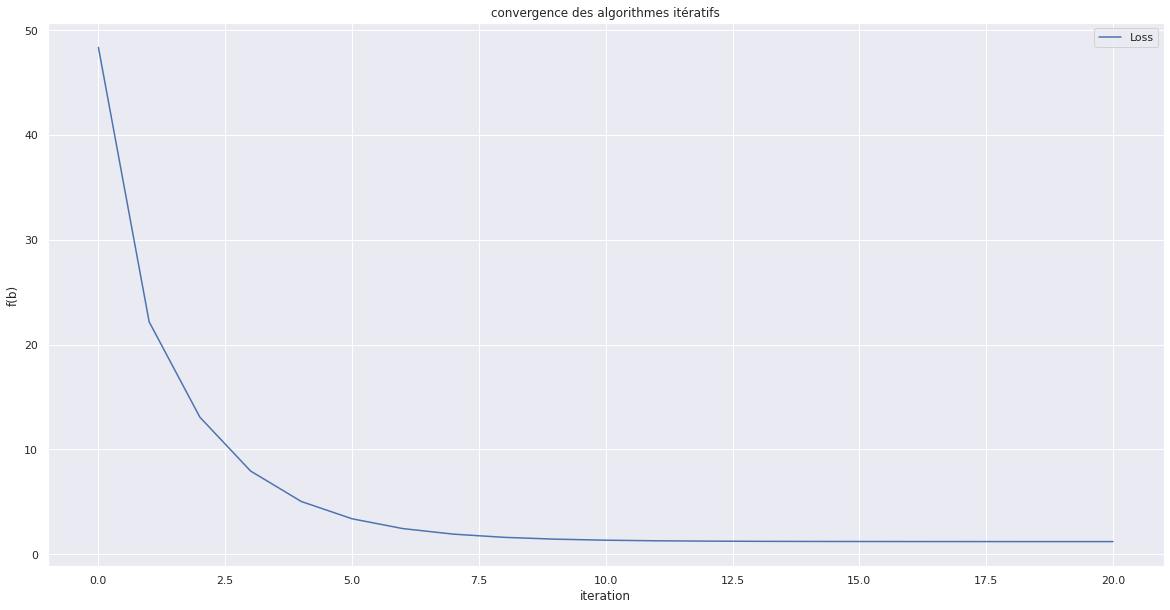

In [3]:
# Linear regression model
import numpy as np
from scipy.stats import laplace
from numpy.linalg import norm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/optimisation')
n, p = 100, 5
X = np.random.randn(n, p-1)
X = np.c_[X, X@np.random.randn(p-1)]  # Rank deficient matrix
beta = np.random.rand(p)
y = X@beta + laplace.rvs(size=n) * 1e-1

iteration = 20
b = np.zeros(p)
f_b = np.zeros(iteration + 1)
lamb = 1 
f_b[0] = (1/2) * (X @ b - y).T @ (X @ b - y) + (lamb/2)*b.T @ b
writer.add_scalar('Loss', f_b[0], 0)
for i in range(iteration):
    gradient_f = X.T @ (X @ b - y) + lamb * b
    U, sigma, VT = np.linalg.svd(X, full_matrices=False)
    L = sigma[0] ** 2 + lamb
    b = b - (1/L) * gradient_f
    f_b[i + 1] = (1/2) * (X @ b - y).T @ (X @ b - y) + (lamb/2)*b.T @ b
    writer.add_scalar('Loss', f_b[i + 1], i + 1)
# Visualisation
sns.set()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(0, iteration + 1), f_b, label="Loss")
ax.set_xlabel('iteration')
ax.set_ylabel('f(b)')
ax.set_title('convergence des algorithmes itératifs')
ax.legend();
    
    
    

In [4]:
# Visualisation with tensorboard
%load_ext tensorboard
%tensorboard --logdir runs/optimisation

Reusing TensorBoard on port 6007 (pid 357448), started 0:09:06 ago. (Use '!kill 357448' to kill it.)